# Toy Problem 2

This jupyter notebook demonstrates the use of the *johnstondechazal* method to determine the optimum ground truth landmark position using a toy problem given a number of ground truth annotations as provided by *expert*, *crowd sourced* and *adversarial* annotators.  In this toy problem each annotator has been asked to identify the location of a single described co-ordinate in a 2D space, three different times.  The *expert* annotators, the higher performing of the group are able to more accurately identify the landmark with greater precision each time, the crowd sourced annotators are less precise in their selections as well as have a poorer understanding of the location of the described landmark.  The *adversarial* annotators, are those who aren't interested in the quality of the completed task but are simply wanting to complete it to obtain the desired incentive; as such their selections are essentially random with no consideration to the requirements of the task.

For the task of annotating ground truth data there is some overall ground truth position $Y_G$ for the problem, though its precise position is unknown by all annotators.  Each group of annotators are able to estimate this position with some deviation, with the *experts* being more likely to determine $Y_G$ and the *adversarial* annotators the least.  Additionally there is some variance for each group in the landmark selected for each independent repetition, again the *experts* having the least amount of variance per selection.

In this notebook we will compare the performance of the *johnstondechazal* method in estimating $Y_G$ compared with simply taking the average value of all selections.

This notebook is a repeat of [ToyProblem2](ToyProblem2.ipynb) using different random seed values.

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

from johnstondechazal import FindGrouthTruth
from johnstondechazal.visualise import plot_history

##### Setup of the Problem #####

# Number of Annotators
A_EXPERTS = 5
A_CROWD = 23
A_ADVERSARIAL = 1

# Replicates
R = 4

# Dimensions
D = 2

# Unknown ground truth value
Y_G = (172, 46)

##### Precision and Variance Selection #####
# Experts
Y_G_EXPERTS = (-4, 2)
EXPERTS_SIGMA = (3, 9)

# Crowd Sourced Workers
Y_G_CROWD = (-3, 8)
CROWD_SIGMA = (2, 22)

# Adversarial Annotators
Y_G_ADV = (40, 80)
ADV_SIGMA = (14, 27)

rng = np.random.default_rng(7689)


## Experts Selections

The following section generates the presents the data if only considering the selections made by the *expert* group.

In [130]:
# Create a sample of annotators
annotators_dist = np.zeros((A_EXPERTS, R, 2))
for i in range(A_EXPERTS):
    annot_mean = Y_G + rng.integers(Y_G_EXPERTS[0], Y_G_EXPERTS[1], size=(1, 2)) + rng.random(size=(1, 2))
    annot_sigma = rng.integers(EXPERTS_SIGMA[0], EXPERTS_SIGMA[1], size=(1, 2)) + rng.random(size=(1, 2))
    annot_dist = np.array(annot_mean) + rng.choice([-1, 1], size=(R, 2)) * np.array(annot_sigma) * rng.random((R, 2))
    annotators_dist[i] = annot_dist

    print(f'Annotator {i}: mean = {annotators_dist[i].mean(axis=0)}, sigma = {annotators_dist[i].std(axis=0)}')
    
annotators_dist = np.array(annotators_dist)

Annotator 0: mean = [171.75731179  47.31730463], sigma = [0.88952715 2.25624939]
Annotator 1: mean = [174.02776382  39.97599827], sigma = [3.45696502 2.09965571]
Annotator 2: mean = [171.62206458  41.70663903], sigma = [1.50582898 4.8819948 ]
Annotator 3: mean = [169.83554719  47.37880535], sigma = [3.09400488 4.46950157]
Annotator 4: mean = [173.51743138  45.83740891], sigma = [1.69030296 4.9284065 ]


In [131]:
meta = {'workerid': [i for i in range(A_EXPERTS)], 'type': A_EXPERTS * ['worker']}

meta = pd.DataFrame.from_dict(meta)  
gt = FindGrouthTruth()
history = gt.converge_select(annotators_dist, meta)

Plot all the landmarks with the ground truth location, the global mean and the *johnstondechazal* localisation.

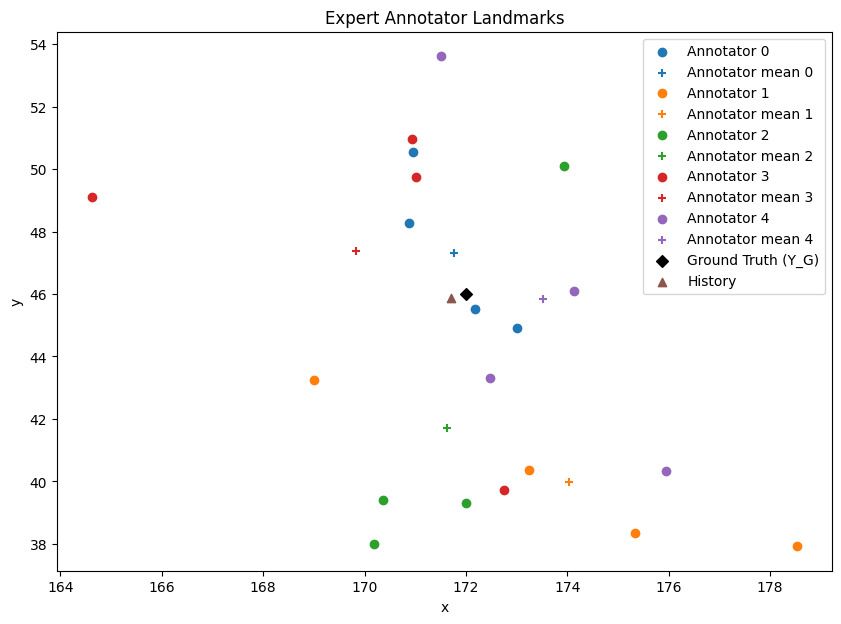

In [132]:
fig, ax = plt.subplots(figsize=(10, 7))
for i in range(A_EXPERTS):
    
    points = ax.scatter(annotators_dist[i, :, 0], annotators_dist[i, :, 1], label=f'Annotator {i}')
    _mu = annotators_dist[i].mean(axis=0)
    plt.scatter(_mu[0], _mu[1], c=points.get_facecolor(), marker='+', label=f'Annotator mean {i}')
    
ax.scatter(Y_G[0], Y_G[1], label='Ground Truth (Y_G)', c='k', marker='D')
_mean = annotators_dist.reshape((-1, 2)).mean(axis=0)

ax.scatter(history.loc[0], history.loc[1], marker='^', label='History')
plt.legend();
plt.title('Expert Annotator Landmarks');
plt.xlabel('x');
plt.ylabel('y');

How does the ground truth estimate change over the iterations of the procedure?

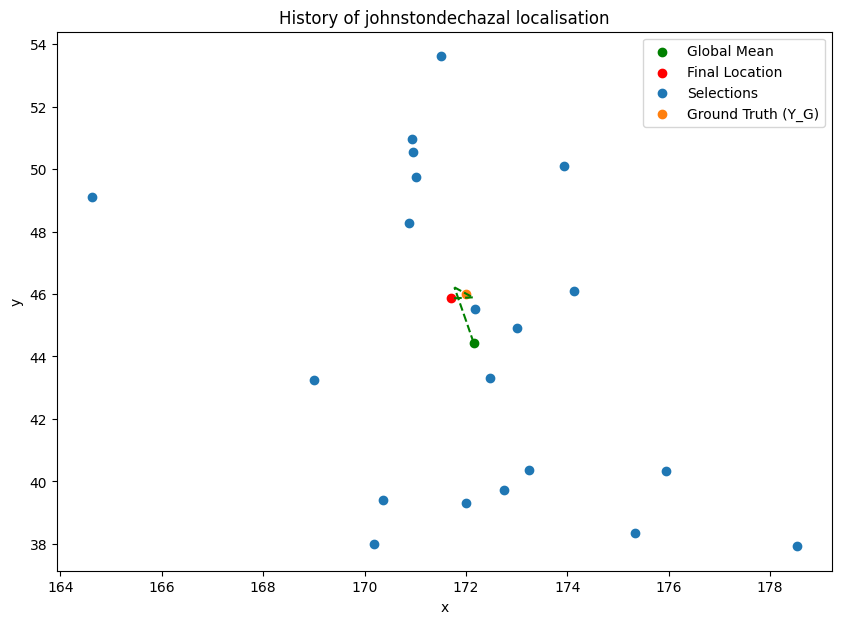

In [133]:
_y = annotators_dist.reshape((-1, 2))
fig, ax = plt.subplots(figsize=(10, 7))

plot_history(history, ax, c=['g', 'r']) # Pass the history object
ax.scatter(_y[:,0], _y[:,1], label='Selections'); # Plot the initial values
ax.scatter(Y_G[0], Y_G[1], label='Ground Truth (Y_G)'); # Plot the ground truth

plt.title('History of johnstondechazal localisation');
plt.legend();
plt.xlabel('x');
plt.ylabel('y');

In [134]:
mean_dist = euclidean(Y_G, _mean)
print(f'Euclidean distance between ground truth mean {Y_G} and global mean {_mean} = {mean_dist: .2f}')
history_dist = euclidean(Y_G, history.loc)
print(f'Euclidean distance between ground truth mean {Y_G} and johnstondechazal mean {history.loc} = {history_dist: .2f}')

Euclidean distance between ground truth mean (172, 46) and global mean [172.15202375  44.44323124] =  1.56
Euclidean distance between ground truth mean (172, 46) and johnstondechazal mean [171.70519742  45.85796023] =  0.33


## Crowd Sourced Workers

In [135]:
# Create a sample of annotators
annotators_dist_crowd = np.zeros((A_EXPERTS + A_CROWD, R, 2))
annotators_dist_crowd[:A_EXPERTS] = annotators_dist

for i in range( A_CROWD):
    annot_mean = Y_G + rng.integers(Y_G_CROWD[0], Y_G_CROWD[1], size=(1, 2)) + rng.random(size=(1, 2))
    annot_sigma = rng.integers(CROWD_SIGMA[0], CROWD_SIGMA[1], size=(1, 2)) + rng.random(size=(1, 2))
    annot_dist = np.array(annot_mean) + rng.choice([-1, 1], size=(R, 2)) * np.array(annot_sigma) * rng.random((R, 2))
    annotators_dist_crowd[A_EXPERTS + i] = annot_dist

    print(f'Adversarial annotator {i}: mean = {annotators_dist_crowd[A_EXPERTS + i].mean(axis=0)}, sigma = {annotators_dist_crowd[A_EXPERTS + i].std(axis=0)}')

Adversarial annotator 0: mean = [170.99521974  50.56684826], sigma = [2.14502129 3.75749581]
Adversarial annotator 1: mean = [172.36732209  45.30893294], sigma = [ 1.31048758 10.79529671]
Adversarial annotator 2: mean = [179.56344837  51.42417726], sigma = [6.56068408 5.64259624]
Adversarial annotator 3: mean = [167.61032473  32.51348895], sigma = [6.33763427 5.2650984 ]
Adversarial annotator 4: mean = [177.42972426  49.73391789], sigma = [3.36387798 6.31935013]
Adversarial annotator 5: mean = [182.04636681  41.73468028], sigma = [10.59890539  6.06115919]
Adversarial annotator 6: mean = [178.899792    42.58503064], sigma = [4.58251778 4.92032524]
Adversarial annotator 7: mean = [178.71680129  46.17994854], sigma = [ 5.6239414  12.11781203]
Adversarial annotator 8: mean = [164.96269964  34.34262171], sigma = [10.93428308  7.35036352]
Adversarial annotator 9: mean = [179.30737553  55.52929596], sigma = [10.33198615  7.25215699]
Adversarial annotator 10: mean = [175.22995375  47.76198692]

In [136]:
meta = {'workerid': [i for i in range(A_EXPERTS + A_CROWD)], 'type': A_EXPERTS * ['worker'] + A_CROWD * ['crowd']}

meta = pd.DataFrame.from_dict(meta)  
gt = FindGrouthTruth()
history = gt.converge_select(annotators_dist_crowd, meta)

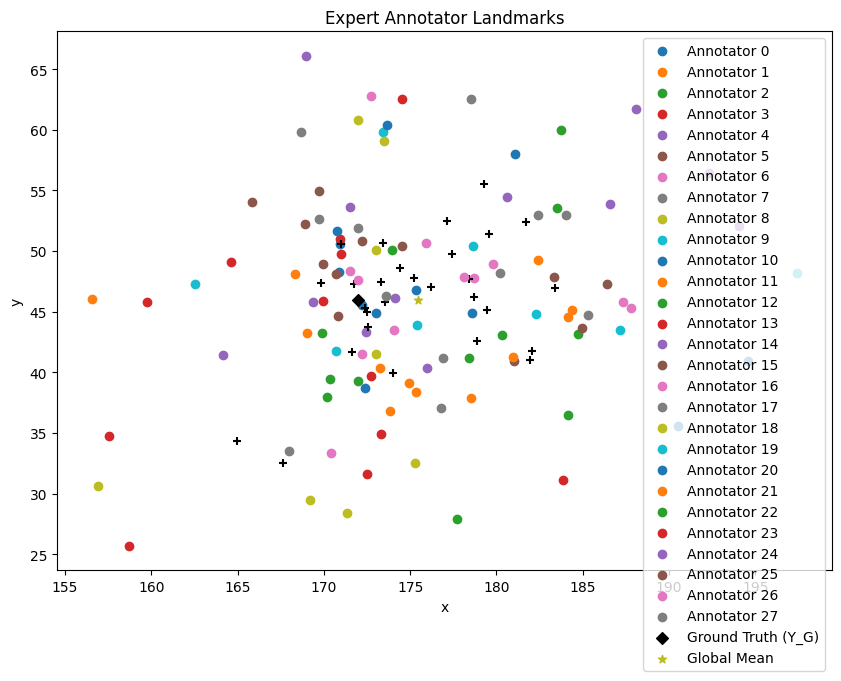

In [137]:
plt.figure(figsize=(10, 7))
for i in range(A_EXPERTS + A_CROWD):
    
    plt.scatter(annotators_dist_crowd[i, :, 0], annotators_dist_crowd[i, :, 1], label=f'Annotator {i}')
    _mu = annotators_dist_crowd[i].mean(axis=0)
    plt.scatter(_mu[0], _mu[1], c='k', marker='+')
    
plt.scatter(Y_G[0], Y_G[1], label='Ground Truth (Y_G)', c='k', marker='D')
_mean = annotators_dist_crowd.reshape((-1, 2)).mean(axis=0)
plt.scatter(_mean[0], _mean[1], marker='*', label='Global Mean')
ax.scatter(history.loc[0], history.loc[1], marker='^', label='History')
plt.legend();
plt.title('Expert Annotator Landmarks');
plt.xlabel('x');
plt.ylabel('y');

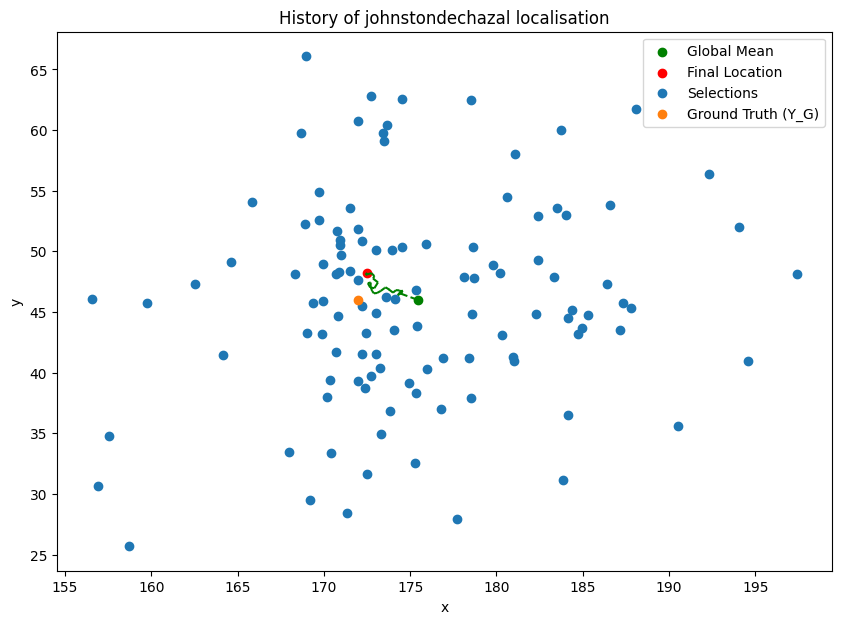

In [138]:
_y = annotators_dist_crowd.reshape((-1, 2))
fig, ax = plt.subplots(figsize=(10, 7))

plot_history(history, ax, c=['g', 'r']) # Pass the history object
ax.scatter(_y[:,0], _y[:,1], label='Selections'); # Plot the initial values
ax.scatter(Y_G[0], Y_G[1], label='Ground Truth (Y_G)'); # Plot the ground truth

plt.title('History of johnstondechazal localisation');
plt.legend();
plt.xlabel('x');
plt.ylabel('y');

In [139]:
mean_dist = euclidean(Y_G, _mean)
print(f'Euclidean distance between ground truth mean {Y_G} and global mean {_mean} = {mean_dist: .2f}')
history_dist = euclidean(Y_G, history.loc)
print(f'Euclidean distance between ground truth mean {Y_G} and johnstondechazal mean {history.loc} = {history_dist: .2f}')

Euclidean distance between ground truth mean (172, 46) and global mean [175.44051152  46.00517945] =  3.44
Euclidean distance between ground truth mean (172, 46) and johnstondechazal mean [172.51541028  48.23560837] =  2.29


## Adversarial Mean

In [140]:
# Create a sample of annotators
annotators_dist_adv = np.zeros((A_EXPERTS + A_CROWD + A_ADVERSARIAL, R, 2))
annotators_dist_adv[:A_EXPERTS + A_CROWD] = annotators_dist_crowd

for i in range(A_ADVERSARIAL):
    annot_mean = Y_G + rng.integers(Y_G_ADV[0], Y_G_ADV[1], size=(1, 2)) + rng.random(size=(1, 2))
    annot_sigma = rng.integers(ADV_SIGMA[0], ADV_SIGMA[1], size=(1, 2)) + rng.random(size=(1, 2))
    annot_dist = np.array(annot_mean) + rng.choice([-1, 1], size=(R, 2)) * np.array(annot_sigma) * rng.random((R, 2))
    annotators_dist_adv[A_EXPERTS + A_CROWD + i] = annot_dist

    print(f'Adversarial annotator {i}: mean = {annotators_dist_adv[A_EXPERTS + A_CROWD + i].mean(axis=0)}, sigma = {annotators_dist_adv[A_EXPERTS + A_CROWD + i].std(axis=0)}')
    

Adversarial annotator 0: mean = [249.54126098 122.154902  ], sigma = [12.35147199 15.1906753 ]


In [141]:
meta = {'workerid': [i for i in range(A_EXPERTS + A_CROWD + A_ADVERSARIAL)], 'type': A_EXPERTS * ['worker'] + A_CROWD * ['crowd'] + A_ADVERSARIAL * ['adversarial']}

meta = pd.DataFrame.from_dict(meta)  
gt = FindGrouthTruth()
history = gt.converge_select(annotators_dist_adv, meta)

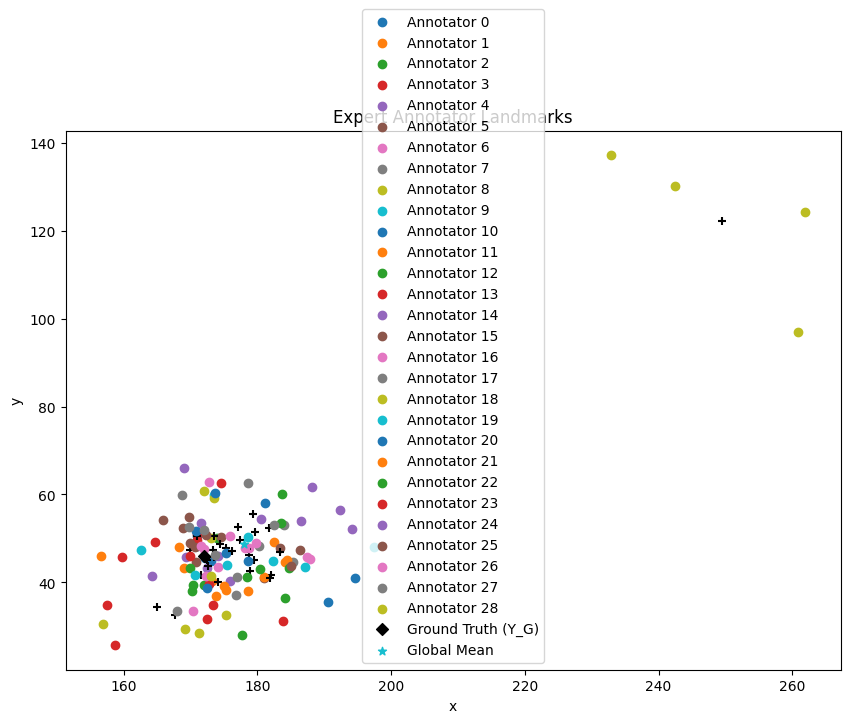

In [142]:
plt.figure(figsize=(10, 7))
for i in range(A_EXPERTS + A_CROWD + A_ADVERSARIAL):
    
    plt.scatter(annotators_dist_adv[i, :, 0], annotators_dist_adv[i, :, 1], label=f'Annotator {i}')
    _mu = annotators_dist_adv[i].mean(axis=0)
    plt.scatter(_mu[0], _mu[1], c='k', marker='+')
    
plt.scatter(Y_G[0], Y_G[1], label='Ground Truth (Y_G)', c='k', marker='D')
_mean = annotators_dist_adv.reshape((-1, 2)).mean(axis=0)
plt.scatter(_mean[0], _mean[1], marker='*', label='Global Mean')
ax.scatter(history.loc[0], history.loc[1], marker='^', label='History')
plt.legend();
plt.title('Expert Annotator Landmarks');
plt.xlabel('x');
plt.ylabel('y');

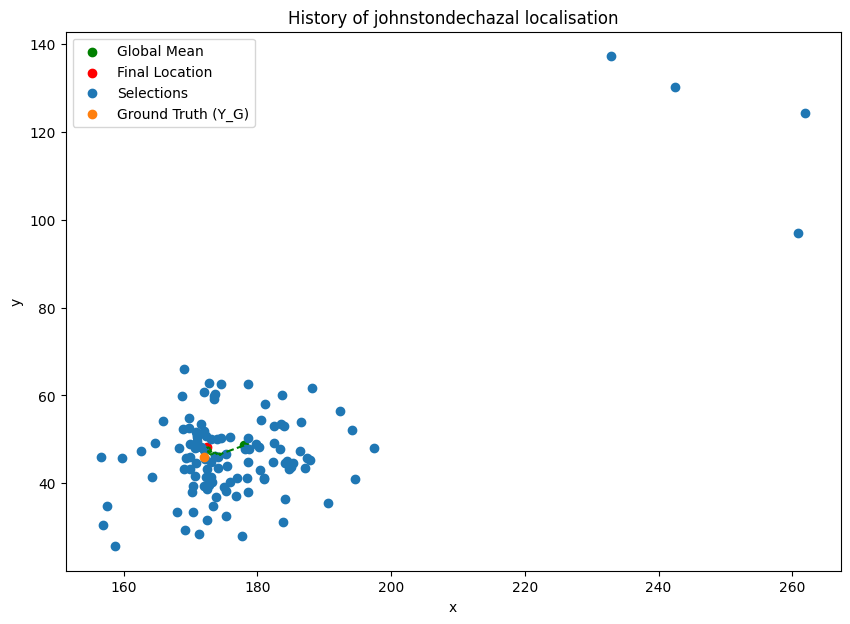

In [143]:
_y = annotators_dist_adv.reshape((-1, 2))
fig, ax = plt.subplots(figsize=(10, 7))

plot_history(history, ax, c=['g', 'r']) # Pass the history object
ax.scatter(_y[:,0], _y[:,1], label='Selections'); # Plot the initial values
ax.scatter(Y_G[0], Y_G[1], label='Ground Truth (Y_G)'); # Plot the ground truth

plt.title('History of johnstondechazal localisation');
plt.legend();
plt.xlabel('x');
plt.ylabel('y');

In [144]:
mean_dist = euclidean(Y_G, _mean)
print(f'Euclidean distance between ground truth mean {Y_G} and global mean {_mean} = {mean_dist: .2f}')
history_dist = euclidean(Y_G, history.loc)
print(f'Euclidean distance between ground truth mean {Y_G} and johnstondechazal mean {history.loc} = {history_dist: .2f}')

Euclidean distance between ground truth mean (172, 46) and global mean [177.99570978  48.63103196] =  6.55
Euclidean distance between ground truth mean (172, 46) and johnstondechazal mean [172.51541028  48.23560837] =  2.29
